In [1]:
import os
import gc
import glob
import pandas as pd
# import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm  # Make sure to install tqdm if you haven't (pip install tqdm)


In [3]:
def top_predictable_genes(df_results: pd.DataFrame, dataset: str, method: str, num: int = 5) -> pd.DataFrame:
    """
    Extracts the top predictable genes based on Pearson correlation for a specific method and dataset.

    Parameters:
        - df_results (pd.DataFrame): The DataFrame containing the results from the make_res function.
        - dataset (str): The dataset name.
        - method (str): The method name.
        - num (int, optional): The number of top predictable genes or "pos" for all positive Pearson correlation values.

    Returns:
        pd.DataFrame: DataFrame containing the top predictable genes and related statistics.
    """
    df = df_results[df_results["Method"] == method]

    if num == "pos":
        top_df = df[["Gene", "Pearson correlation"]].groupby("Gene", as_index=False).agg(
            ['median', 'mean', 'max', 'min', 'std']
        ).sort_values(by=('Pearson correlation', 'median'), ascending=False)
    else:
        top_df = df[["Gene", "Pearson correlation"]].groupby("Gene", as_index=False).agg(
            ['median', 'mean', 'max', 'min', 'std']
        ).sort_values(by=('Pearson correlation', 'median'), ascending=False).head(num)

    top_genes = list(top_df.index)

    # Calculate the number of consistent samples for each top gene
    num_pos = [df[df["Gene"] == g]['Pearson correlation'].gt(0).sum() for g in top_genes]

    # Create the final DataFrame with relevant columns
    top_df["Number of consistent samples"] = num_pos
    top_df["Method"] = method
    top_df["Dataset"] = dataset
    top_df = top_df[[('Method', ''), ('Dataset', ''), ('Number of consistent samples', ''),
                     ('Pearson correlation', 'mean'), ('Pearson correlation', 'median'),
                     ('Pearson correlation', 'min'), ('Pearson correlation', 'max'),
                     ('Pearson correlation', 'std')]]

    return top_df


In [4]:
# Specify the directory where CSV files are located
results_directory = "../Results/Summary/"

# Use os.path.join for path construction
csv_files = glob.glob(os.path.join(results_directory, '*_summary_MI_func.csv'))

# Use tqdm to add a progress bar during concatenation
dfs = []
for csv_file in tqdm(csv_files, desc='Reading CSV files', unit='file'):
    df = pd.read_csv(csv_file, index_col=[0])
    dfs.append(df)

# Concatenate all DataFrames into one
df = pd.concat(dfs, ignore_index=True)

# Display the concatenated DataFrame
df.head()


Reading CSV files: 100%|██████████| 6/6 [00:00<00:00,  9.47file/s]


,index,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SPC_PValue,SSIM_Score,Cosine_Score,Moran'I_Score,Slides,Dataset,Method
0,0,FYB1,0.037944,3.703762e-03,0.073832,9.137931e-08,0.003988,0.133517,0.048471,C73_C1_VISIUM,Liver_visium,hist2st
1,1,MME,0.248987,1.493047e-71,0.303691,4.709541e-107,0.116664,0.552686,0.250680,C73_C1_VISIUM,Liver_visium,hist2st
2,2,CKAP5,0.082806,2.426433e-09,0.106306,2.710782e-14,0.006528,0.213023,0.080914,C73_C1_VISIUM,Liver_visium,hist2st
3,3,MAP2K1,0.291781,1.266866e-98,0.336820,1.148629e-132,0.138727,0.605552,0.289929,C73_C1_VISIUM,Liver_visium,hist2st
4,4,CAST,0.179371,1.397628e-37,0.254622,7.741252e-75,0.065898,0.526105,0.173970,C73_C1_VISIUM,Liver_visium,hist2st


In [5]:
# Define mapping dictionaries for model and dataset names
model_mapping = {
    'deeppt': "DeepPT",
    'histogene': "HisToGene",
    'His2gene': "HisToGene",
    'stnet': "STnet",
    'hist2st': "Hist2ST",
    'stimage': "STimage",
    'bleep': "BLEEP",
    'deepspace': "DeepSpaCE"
}

dataset_mapping = {
    'SCC_Chenhao': "Skin_Melanoma",
    'Skin_cscc': "Skin_cSCC",
    'Liver_bleep': "Liver_Visium",
    'Liver_visium': "Liver_Visium",
    'BC_visium': "BC_Visium",
    'Kidney_visium': "Kidney_Visium"
}

# Replace model and dataset names in the DataFrame
df.replace({'Method': model_mapping, 'Dataset': dataset_mapping}, inplace=True)

# Define the order for Dataset and Method columns
dataset_order = ['BC_Her2ST', 'BC_Visium', 'Skin_cSCC', 'Skin_Melanoma', 'Kidney_Visium', 'Liver_Visium']
method_order = ['STnet', 'HisToGene', 'Hist2ST', 'DeepSpaCE', 'STimage', 'BLEEP', 'DeepPT']

# Use pd.Categorical directly during DataFrame creation
df['Dataset'] = pd.Categorical(df['Dataset'], categories=dataset_order, ordered=True)
df['Method'] = pd.Categorical(df['Method'], categories=method_order, ordered=True)


In [6]:
# Specify the directory for functional gene results
functional_results_directory = "../Results/Summary/"

# Specify the directory for predictable gene results
predictable_results_directory = "../Results/Predictable_res4/"

# List of dataset names
datasets = ["Skin_Melanoma", "BC_Her2ST", "Liver_visium", "Skin_cSCC", "Kidney_visium", "BC_visium"]

# # Iterate over datasets
# for dataset_name in datasets:
#     # Read the functional gene results for the current dataset
#     df_func = pd.read_csv(os.path.join(functional_results_directory, f"{dataset_name}_summary_MI_func.csv"))

#     # List of methods
#     # methods = ["deeppt", "hist2st", "histogene", "stimage", "bleep", "stnet", "deepspace"]
#     methods = ["deeppt", "stimage", "bleep", "deepspace"]

#     # Get predictable genes for each method
#     predictable_genes_sets = [set(top_predictable_genes(df_func, dataset_name, method, num=500).index) for method in methods]

#     # Find the intersection of predictable genes across all methods
#     predictable_genes = list(set.intersection(*predictable_genes_sets))
#     print(f"There are {len(predictable_genes)} genes that are predictable by all methods for {dataset_name}.")

#     # Subset the original DataFrame for predictable genes
#     df_predictable = df_func[df_func["Gene"].isin(predictable_genes)].reset_index(drop=True)

#     # Save the results for predictable genes
#     predictable_results_path = os.path.join(predictable_results_directory, f"predictable_{dataset_name}_func.csv")
#     df_predictable.to_csv(predictable_results_path)

# Load the results of predictable genes
predictable_results_glob = os.path.join(predictable_results_directory, "predictable_*_func.csv")
df_combined_predictable = pd.concat([pd.read_csv(r, index_col=[0]) for r in glob.glob(predictable_results_glob)], ignore_index=True)
df_combined_predictable


,Unnamed: 0.1,index,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SPC_PValue,SSIM_Score,Cosine_Score,Moran'I_Score,Slides,Dataset,Method
0,1,1,CD14,0.052389,0.105855,0.038065,0.182173,0.019641,0.869125,0.000367,E2,BC_Her2ST,histogene
1,2,2,NOTCH1,0.026907,0.260726,0.015441,0.356486,0.007120,0.407320,-0.000910,E2,BC_Her2ST,histogene
2,8,8,ERRFI1,-0.010376,0.597614,0.003268,0.468971,0.001319,0.359955,0.024121,E2,BC_Her2ST,histogene
3,10,10,STAT2,0.017581,0.337662,0.030029,0.237143,0.010954,0.826604,0.019334,E2,BC_Her2ST,histogene
4,11,11,NASP,0.012331,0.384469,0.007353,0.430473,0.005341,0.508852,0.000090,E2,BC_Her2ST,histogene
...,...,...,...,...,...,...,...,...,...,...,...,...,...
187231,71540,1676,DPP4,-0.004302,0.578375,0.000223,0.495918,0.003278,0.397973,0.014745,C,Kidney_visium,histogene
187232,71542,1678,SYPL1,-0.035360,0.947997,-0.024532,0.870278,-0.003183,0.620242,-0.052073,C,Kidney_visium,histogene
187233,71547,1683,PPP2CB,-0.089437,0.999981,-0.074644,0.999704,-0.014372,0.649790,-0.071583,C,Kidney_visium,histogene
187234,71548,1684,TNFRSF1B,0.024884,0.126333,0.034481,0.056448,0.004856,0.241384,0.005331,C,Kidney_visium,histogene


In [24]:
g_BC_Her2ST = set(df_combined_predictable[df_combined_predictable['Dataset']=='BC_Her2ST']['Gene'])
g_BC_visium = set(df_combined_predictable[df_combined_predictable['Dataset']=='BC_visium']['Gene'])
print(len(g_BC_Her2ST))
print(len(g_BC_visium))
g_BC_comb = g_BC_Her2ST & g_BC_visium
len(g_BC_comb)

373
344


229

In [7]:
# Define mapping dictionaries for model and dataset names
model_mapping = {
    'deeppt': "DeepPT",
    'histogene': "HisToGene",
    'His2gene': "HisToGene",
    'stnet': "STnet",
    'hist2st': "Hist2ST",
    'stimage': "STimage",
    'bleep': "BLEEP",
    'deepspace': "DeepSpaCE"
}

dataset_mapping = {
    'SCC_Chenhao': "Skin_Melanoma",
    'Skin_cscc': "Skin_cSCC",
    'Liver_bleep': "Liver_Visium",
    'Liver_visium': "Liver_Visium",
    'BC_visium': "BC_Visium",
    'Kidney_visium': "Kidney_Visium"
}

# Replace model and dataset names in the DataFrame
df_combined_predictable.replace({'Method': model_mapping, 'Dataset': dataset_mapping}, inplace=True)

# Define the order for Dataset and Method columns
dataset_order = ['BC_Her2ST', 'BC_Visium', 'Skin_cSCC', 'Skin_Melanoma', 'Kidney_Visium', 'Liver_Visium']
method_order = ['STnet', 'HisToGene', 'Hist2ST', 'DeepSpaCE', 'STimage', 'BLEEP', 'DeepPT']

# Use pd.Categorical directly during DataFrame creation
df_combined_predictable['Dataset'] = pd.Categorical(df_combined_predictable['Dataset'], categories=dataset_order, ordered=True)
df_combined_predictable['Method'] = pd.Categorical(df_combined_predictable['Method'], categories=method_order, ordered=True)


In [8]:
def set_ymargin(ax, left=0.0, right=0.3):
    ax.set_ymargin(0)
    ax.autoscale_view()
    lim = ax.get_ylim()
    delta = np.diff(lim)
    # delta = 1
    left = lim[0] - delta*left
    right = lim[1] + delta*right
    ax.set_ylim(left,right)


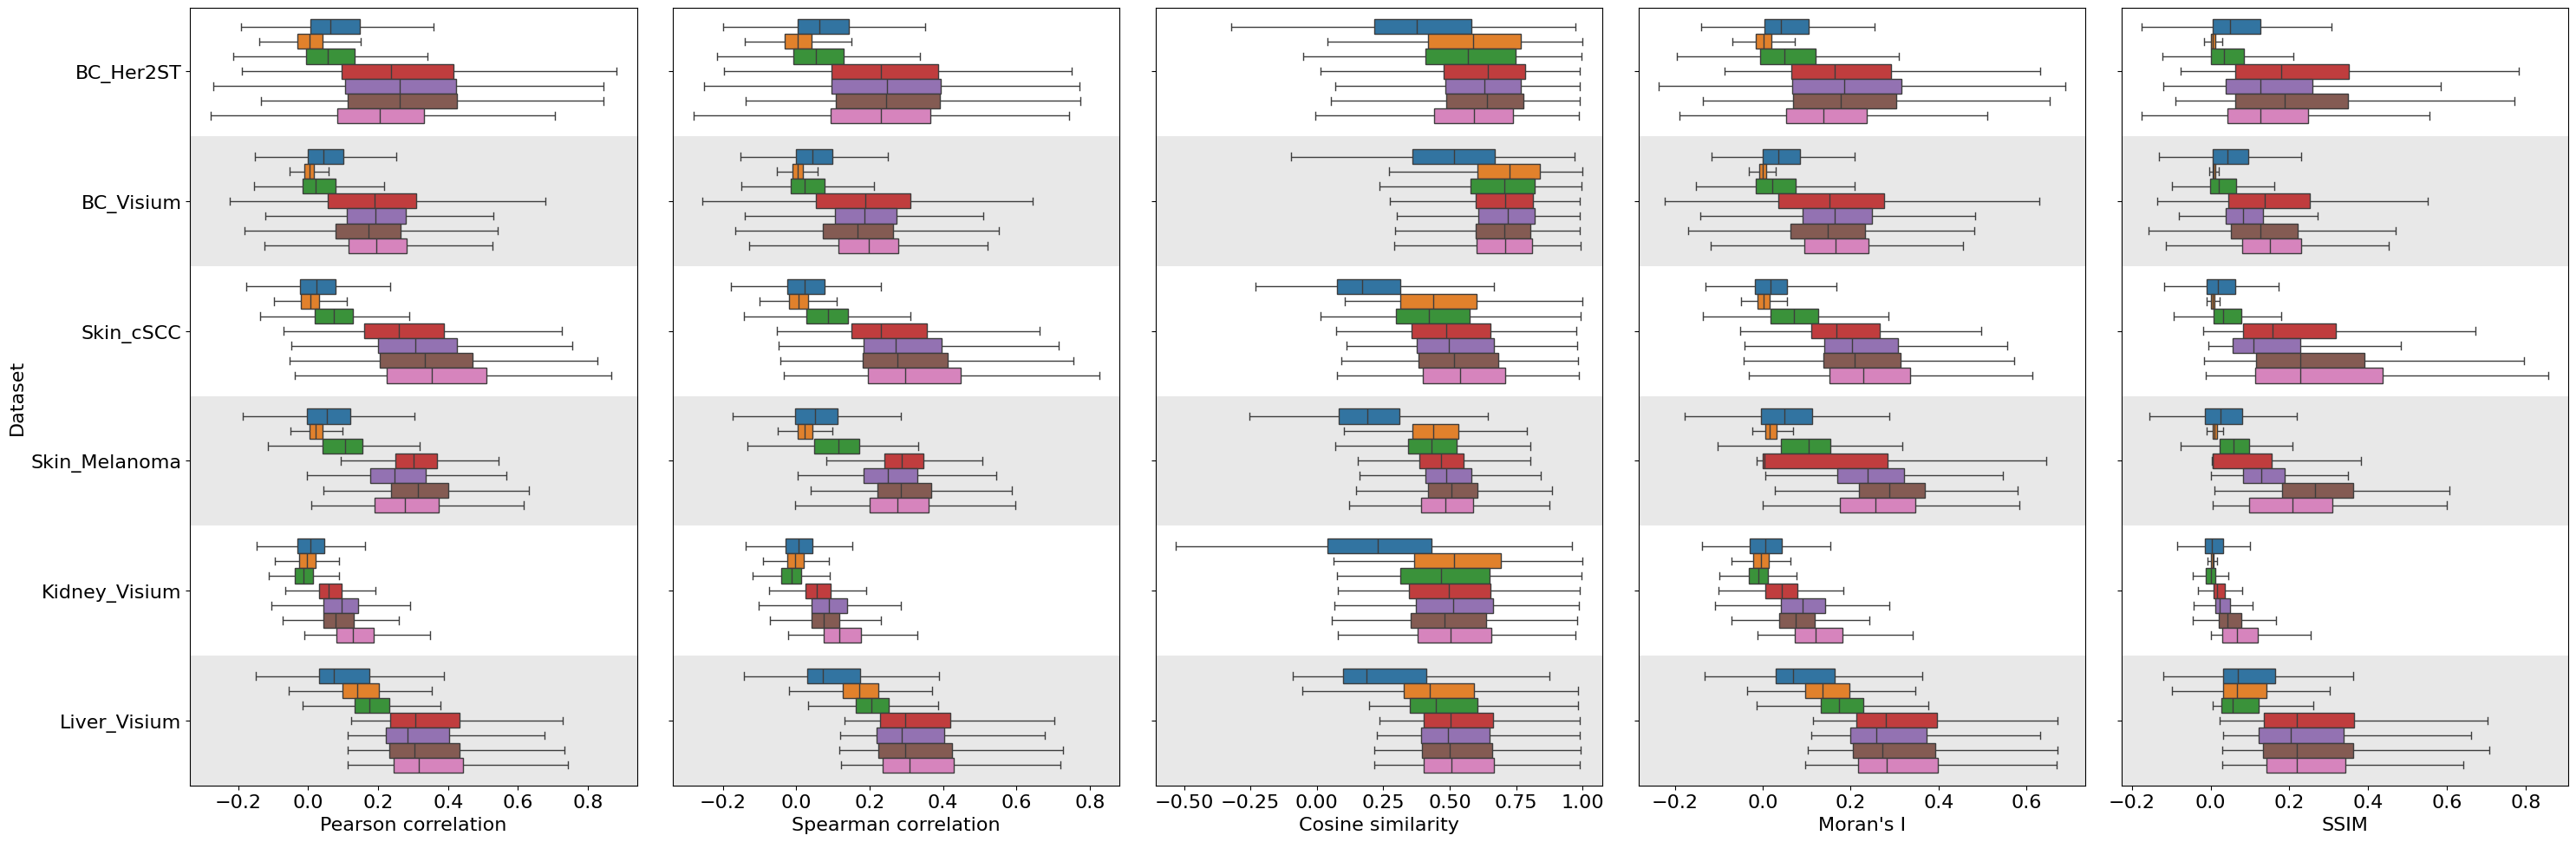

911

In [9]:
# Collect garbage to free up memory
gc.collect()

# Set the font size for better readability
plt.rcParams.update({'font.size': 16})

# Create subplots with 4 rows and 1 column
fig, axs = plt.subplots(1, 5, figsize=(30, 10))

# List of columns and corresponding y-axis labels for plotting
columns_to_plot = [
    ('Pearson correlation', 'Pearson correlation', False),
    ('Spearmanr correlation', 'Spearman correlation', False),
    ('Cosine_Score', 'Cosine similarity', False),
    ("Moran'I_Score", "Moran's I", False),
    ('SSIM_Score', 'SSIM', False),
]

# Loop through the columns and plot on the corresponding subplot
for i, (column, ylabel, add_legend) in enumerate(columns_to_plot):
    # sns.boxplot(x='Dataset', y=column, hue='Method', data=df_combined_predictable, ax=axs[i], showfliers=False)
    sns.boxplot(x=column, y='Dataset', hue='Method', data=df_combined_predictable, ax=axs[i], showfliers=False)
    
    # Remove legend for all subplots except the first one
    if not add_legend:
        axs[i].get_legend().remove()
    
    if i>0:
        axs[i].set_ylabel('')  # Remove x label for all subplots
    
    # Set y-axis label
    axs[i].set_xlabel(ylabel)

for ax in axs[1:]:
    # ax.sharex(axs[0])
    ax.set_yticklabels([])

for ax in axs:
    ax.axhspan(0.5,1.5, facecolor='lightgray', alpha=0.5)
    ax.axhspan(2.5,3.5, facecolor='lightgray', alpha=0.5)
    ax.axhspan(4.5,5.5, facecolor='lightgray', alpha=0.5)
    set_ymargin(ax, left=0, right=0.015)

# Move the legend outside the plot area only for the first subplot
pos = axs[0].get_position()
# axs[0].set_position([pos.x0, pos.y0, pos.width, pos.height * 1])
# axs[0].legend(
#     loc='upper center',
#      bbox_to_anchor=(0.5, 1.05),
#           ncol=7
# )
# Adjust layout to prevent overlapping
plt.tight_layout()

# Save the plots as a PDF file
# plt.savefig("Figure2.pdf")

# Show the plotsd
plt.show()

# Collect garbage to free up memory
gc.collect()


In [10]:
import pickle
with open('/scratch/user/uqjxie6/DeepHis2Exp/Figures/fig2_neww.pkl', 'wb') as file:
    pickle.dump(df_combined_predictable, file)